In [1]:
import os
from typing import NamedTuple

import cv2
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

2023-04-15 19:26:32.517034: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 19:26:32.518298: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-15 19:26:32.545627: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-15 19:26:32.546221: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 19:26:33.076155: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.3,
    min_tracking_confidence=0.5,
)
mp_drawing = mp.solutions.drawing_utils

mp_drawing_styles = mp.solutions.drawing_styles
landmark_style = mp_drawing_styles.get_default_hand_landmarks_style()

connection_style = mp_drawing_styles.get_default_hand_connections_style()

In [15]:
def dataset_files(dataset_dir: str = "../dataset/", class_size: int = 70) -> list[tuple[int, str]]:
    files_dataset = []
    for dir_label in sorted(os.listdir(dataset_dir)):
        dir_label_path = dataset_dir + dir_label
        if os.path.isfile(dir_label_path):
            continue
        dir_label_path += "/"
        index = int(dir_label.split("_")[0])
        files = os.listdir(dir_label_path)
        files_dataset.extend([(index, dir_label_path + img_path) for img_path in np.random.choice(files, size=class_size)])
    return files_dataset

In [4]:
def test_images():
    for key, value in files_dataest.items():
        image = cv2.imread(value[0])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    landmark_style,
                    connection_style,
                )
        plt.imshow(image)
        plt.title(key)
        plt.show()

In [5]:
files = dataset_files()
files[:5]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


[(0, '../dataset/00_two_fingers_near/test_130.jpg'),
 (0, '../dataset/00_two_fingers_near/test_370.jpg'),
 (0, '../dataset/00_two_fingers_near/test_120.jpg'),
 (0, '../dataset/00_two_fingers_near/test_390.jpg'),
 (0, '../dataset/00_two_fingers_near/test_530.jpg')]

In [6]:
def process_image(filename: str) -> NamedTuple:
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = hands.process(image)
    return results

In [7]:
def process(filename: str) -> np.ndarray:
    results = process_image(filename)
    if results.multi_hand_landmarks is None:
        return None
    landmarks = results.multi_hand_landmarks[0].landmark

    # Get the position of the wrist landmark (Landmark.WRIST)
    wrist_position_x, wrist_position_y = (
        landmarks[mp.solutions.hands.HandLandmark.WRIST].x,
        landmarks[mp.solutions.hands.HandLandmark.WRIST].y,
    )

    # Normalize the landmarks relative to the wrist position
    normalized_landmarks = []
    for landmark in landmarks:
        normalized_landmarks.append((landmark.x - wrist_position_x, landmark.y - wrist_position_y))  # landmark.z
    normalized_landmarks = np.array(normalized_landmarks).flatten()
    normalized_landmarks /= max(abs(normalized_landmarks))
    return normalized_landmarks

In [8]:
arr = []
for label, file_path in tqdm(dataset_files()):
    result = process(file_path)
    if result is None:
        continue
    result = np.append(result, label)
    arr.append(result)

  0%|          | 0/980 [00:00<?, ?it/s]

In [9]:
arr = np.stack(arr)
arr[:2]

array([[ 0.00000000e+00,  0.00000000e+00,  4.44360700e-02,
        -1.03808648e-01,  4.00798540e-02, -2.77725374e-01,
        -2.89767195e-02, -4.21981806e-01, -8.94244189e-02,
        -5.23506707e-01,  1.05966367e-01, -4.82416465e-01,
         9.76239050e-02, -6.80546006e-01,  8.38208392e-02,
        -8.13659037e-01,  6.90075982e-02, -9.32301102e-01,
         4.16673268e-02, -5.07151103e-01,  4.04319414e-02,
        -7.25125944e-01,  1.61790716e-02, -8.71698491e-01,
        -4.54179558e-03, -1.00000000e+00, -1.61304360e-02,
        -4.74242932e-01, -7.77790724e-02, -6.35047133e-01,
        -9.81370207e-02, -5.45507093e-01, -1.00209447e-01,
        -4.70625892e-01, -6.49037350e-02, -3.92737867e-01,
        -1.15849280e-01, -4.72796269e-01, -1.07482819e-01,
        -3.80417060e-01, -8.51475490e-02, -2.97516686e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  8.43363446e-02,
         1.82667090e-02,  1.84683968e-01, -1.03888063e-01,
         1.86866901e-01, -2.56

In [10]:
col_names = sum([[f"x{i}", f"y{i}"] for i in range(1, 22)], [])
col_names.append("label")

In [11]:
with open("processed.npy", "wb") as f:
    np.save(f, arr)

In [12]:
arr.shape

(918, 43)

(array([70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70., 70.,
        70.]),
 array([ 0.        ,  0.92857143,  1.85714286,  2.78571429,  3.71428571,
         4.64285714,  5.57142857,  6.5       ,  7.42857143,  8.35714286,
         9.28571429, 10.21428571, 11.14285714, 12.07142857, 13.        ]),
 <BarContainer object of 14 artists>)

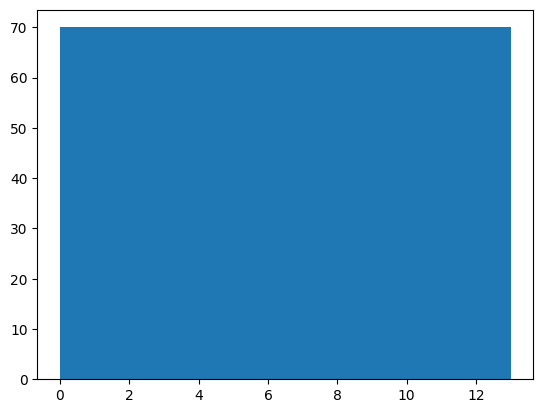

In [14]:
plt.hist([label for label, _ in dataset_files()], bins=14)